In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar

# math and data
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
data_in_path = '/glade/u/home/zcleveland/scratch/ERA5/dsw/'  # path to subset data
my_corr_path = '/glade/u/home/zcleveland/scratch/ERA5/correlations/'  # path to my correlation datasets
cp_in_path = '/glade/u/home/zcleveland/scratch/ERA5/cp/'  # path to subset CP data
sub_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/subsetting/'  # path to subsetting scripts
plot_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/plotting/'  # path to plotting scripts
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/correlations/'  # path to generated figures
temp_scratch_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/temp/'  # path to temp directory in scratch

In [3]:
# define list of variables

# surface instantaneous variables
sfc_instan_list = [
    'sd',  # snow depth  (m of water equivalent)
    'msl',  # mean sea level pressure (Pa)
    'tcc',  # total cloud cover (0-1)
    'stl1',  # soil temp layer 1 (K)
    'stl2',  # soil temp layer 2 (K)
    'stl3',  # soil temp layer 3 (K)
    'stl4',  # soil temp layer 4 (K)
    'swvl1',  # soil volume water content layer 1 (m^3 m^-3)
    'swvl2',  # soil volume water content layer 2 (m^3 m^-3)
    'swvl3',  # soil volume water content layer 3 (m^3 m^-3)
    'swvl4',  # soil volume water content layer 4 (m^3 m^-3)
    '2t',  # 2 meter temp (K)
    '2d',  # 2 meter dew point (K)
    'ishf',  # instant surface heat flux (W m^-2)
    'ie',  # instant moisture flux (kg m^-2 s^-1)
    'cape',  # convective available potential energy (J kg^-1)
    'tcw',  # total column water (kg m^-2) -- sum total of solid, liquid, and vapor in a column
    'sstk',  # sea surface temperature (K)
]

# surface accumulation variables
sfc_accumu_list = [
    'lsp',  # large scale precipitation (m of water)
    'cp',  # convective precipitation (m of water)
    'tp',  # total precipitation (m of water) -- DERIVED
    'sshf',  # surface sensible heat flux (J m^-2)
    'slhf',  # surface latent heat flux (J m^-2)
    'ssr',  # surface net solar radiation (J m^-2)
    'str',  # surface net thermal radiation (J m^-2)
    'sro',  # surface runoff (m)
    'sf',  # total snowfall (m of water equivalent)
    'ssrd',  # surface solar radiation downwards (J m^-2)
    'strd',  # surface thermal radiation downwards (J m^-2)
    'ttr',  # top net thermal radiation (OLR, J m^-2) -- divide by time (s) for W m^-2
]

# pressure level variables
pl_var_list = [
    # 'pv',  # potential vorticity (K m^2 kg^-1 s^-1)
    # 'crwc',  # specific rain water content (kg kg^-1)
    # 'cswc',  # specific snow water content (kg kg^-1)
    'z',  # geopotential (m^2 s^2)
    't',  # temperature (K)
    'u',  # u component of wind(m s^-1)
    'v',  # v component of wind (m s^-1)
    'q',  # specific humidity (kg kg^-1)
    'w',  # vertical velo|city (Pa s^-1)
    # 'vo',  # vorticity - relative (s^-1)
    # 'd',  # divergence (s^-1)
    'r',  # relative humidity (%)
    # 'clwc',  # specific cloud liquid water content
    # 'ciwc',  # specific cloud ice water content
    # 'cc',  # fraction of cloud cover (0-1)
]

# NAM variables
NAM_var_list = [
    'onset',
    'retreat',
    'length'
]

In [4]:
var_dict = {
    'sd': 'Snow Depth',
    'msl': 'Mean Sea Level Pressure',
    'tcc': 'Total Cloud Cover',
    'stl1': 'Soil Temp Layer 1',
    'stl2': 'Soil Temp Layer 2',
    'stl3': 'Soil Temp Layer 3',
    'stl4': 'Soil Temp Layer 4',
    'swvl1': 'Soil Volume Water Content Layer 1',
    'swvl2': 'Soil Volume Water Content Layer 2',
    'swvl3': 'Soil Volume Water Content Layer 3',
    'swvl4': 'Soil Volume Water Content Layer 4',
    '2t': '2 Meter Temp',
    '2d': '2 Meter Dew Point',
    'ishf': 'Instant Surface Heat Flux',
    'ie': 'Instant Moisture Flux',
    'cape': 'Convective Available Potential Energy',
    'tcw': 'Total Column Water',
    'sstk': 'Sea Surface Temperature',
    'lsp': 'Large Scale Precipitation',
    'cp': 'Convective Precipitation',
    'tp': 'Total Precipitation',
    'sshf': 'Surface Sensible Heat Flux',
    'slhf': 'Surface Latent Heat Flux',
    'ssr': 'Surface Net Solar Radiation',
    'str': 'Surface Net Thermal Radiation',
    'sro': 'Surface Runoff',
    'sf': 'Total Snowfall',
    'ssrd': 'Surface Solar Radiation Downwards',
    'strd': 'Surface Thermal Radiation Downwards',
    'ttr': 'Top Net Thermal Radiation (OLR)',
    'z': 'Geopotential',
    't': 'Temperature',
    'u': 'U Component of Wind',
    'v': 'V Component of Wind',
    'q': 'Specific Humidity',
    'w': 'Vertical Velocity',
    'r': 'Relative Humidity',
    'onset': 'Onset',
    'retreat': 'Retreat',
    'length': 'Length'
}

In [5]:
var_units = {
    'sd': '(m)',
    'msl': '(Pa)',
    'tcc': '(0-1)',
    'stl1': '(K)',
    'stl2': '(K)',
    'stl3': '(K)',
    'stl4': '(K)',
    'swvl1': '$(m^3 m^{-3})$',
    'swvl2': '$(m^3 m^{-3})$',
    'swvl3': '$(m^3 m^{-3})$',
    'swvl4': '$(m^3 m^{-3})$',
    '2t': '(K)',
    '2d': '(K)',
    'ishf': '$(W m^{-2})$',
    'ie': '$(kg m^{-2} s^{-1})$',
    'cape': '$(J kg^{-1})$',
    'tcw': '$(kg m^{-2})$',
    'sstk': '(K)',
    'lsp': '(m)',
    'cp': '(m)',
    'tp': '(m)',
    'sshf': '$(J m^{-2})$',
    'slhf': '$(J m^{-2})$',
    'ssr': '$(J m^{-2})$',
    'str': '$(J m^{-2})$',
    'sro': '(m)',
    'sf': '(m)',
    'ssrd': '$(J m^{-2})$',
    'strd': '$(J m^{-2})$',
    'ttr': '$(J m^{-2})$',
    'z': '$(m^2 s^{-2})$',
    't': '(K)',
    'u': '$(m s^{-1})$',
    'v': '$(m s^{-1})$',
    'q': '$(kg kg^{-1})$',
    'w': '$(Pa s^{-1})$',
    'r': '(%)',
    'onset': '',
    'retreat': '',
    'length': ''
}

In [6]:
def plot_onset_correlation(var='swvl1',months=[3, 4, 5], cp_flag=False, overwrite_flag=False):

    # create string to make directory path for figure save
    if cp_flag:
        var_region = 'cp'
    else:
        var_region = 'dsw'

    # create list of months over which to average
    var_months_list = months  # [int(m) for m in str(months)]  # turn var integer into list (e.g. 678 -> [6,7,8])
    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    var_months = ''.join([calendar.month_name[m][0] for m in var_months_list])

    # path to save figures
    out_fn = f'corr_{var}_onset_{var_months}_{var_region}.png'
    out_fp = os.path.join(plot_out_path, 'correlations', var_region, out_fn)

    # check existence of plot already
    if not overwrite_flag:
        if os.path.exists(out_fp):
            print(f'Plot already exists for: corr_{var}_onset_{var_months}_{var_region}')
            print('\nSet overwrite_flag = True to overwrite')
            print('\nSkipping . . .')
            # return

    # open correlation dataset
    corr_file = f'{my_corr_path}{var_region}/corr_{var}_onset_{var_months}_{var_region}.nc'
    var_ds = xr.open_mfdataset(corr_file)['__xarray_dataarray_variable__']

    # plot the results
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))

    levels = np.arange(-1, 1.05, 0.05)
    # plot the data using contourf
    cf = plt.contourf(var_ds.longitude, var_ds.latitude,
                      var_ds, levels=levels,
                      cmap='RdBu_r', vmin=-1, vmax=1)

    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # plot features
    plt.title(f'Correlation Between Start Date of the Monsoon and {var.upper()} ({var_months})')
    plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient')
    plt.tight_layout()
    plt.savefig(out_fp, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# plot correlations with vars and dsw onset
for var in var_list:
    plot_onset_correlation(var=var, months=[3, 4, 5])

In [ ]:
# plot correlations with cp vars and dsw onset
for var in var_list:
    plot_onset_correlation(var=var, months=[3, 4, 5], cp_flag=True)

In [ ]:
# plot correlation with onset and summer precip
plot_onset_correlation(var='tp', months=[6, 7, 8], cp_flag=False)

In [ ]:
# plot correlation with onset and summer AND fall precip
plot_onset_correlation(var='tp', months=[6, 7, 8, 9, 10, 11], cp_flag=False)

In [ ]:
# plot correlation with onset and YEARLY precip
plot_onset_correlation(var='tp', months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], cp_flag=False)

In [6]:
# define a function to turn a list of integers into months
def month_num_to_name(var, months):

    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    if var in NAM_var_list:
        var_months = ''
    elif len(months) == 1:
        var_months = calendar.month_name[months[0]]  # use full month name if only 1 month
    elif ((len(months) > 1) & (len(months) <= 12)):
        var_months = ''.join([calendar.month_name[m][0] for m in months])
    return var_months


In [71]:
# define a function to plot the correlation of 2 variables
def plot_correlation(var1='swvl1', var1_level=700, var1_month_list=[3, 4, 5], var1_region='cp',
                     var2='tp', var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw'):

    # months list
    var1_months = month_num_to_name(var=var1, months=var1_month_list)
    var2_months = month_num_to_name(var=var2, months=var2_month_list)

    fn_list = [str(var1), str(var1_months), str(var1_region), str(var2), str(var2_months), str(var2_region)]
    fn_core = '_'.join([i for i in fn_list if i != ''])

    # filename and path
    in_fn = f'corr_{fn_core}.nc'
    in_fp = os.path.join(my_corr_path, 'domain', in_fn)
    out_fn = f'corr_{fn_core}.png'
    out_fp = os.path.join(plot_out_path, 'domain/temp', out_fn)

    # check existence of input file
    if not os.path.exists(in_fp):
        print(f'corr file not found : {in_fp}')
        return

    # # check existence of file already
    # if os.path.exists(out_fp):
    #     print(f'File already exists for: {out_fn}')
    #     print('Skipping . . .')
    #     return

    # open dataset
    ds = xr.open_dataset(in_fp)
    da = ds['pearson_r']

    # create mask
    mask = np.abs(da) > .3
    da_masked = da.where(mask)

    # plot the results
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))

    levels = np.arange(-1, 1.05, 0.05)
    masked_levels = [-1, -0.3, 0.3, 1]
    hatches = ['.', None, '.']
    # plot the data using contourf
    cf = plt.contourf(da.longitude, da.latitude,
                      da, levels=levels,
                      cmap='RdBu_r', vmin=-1, vmax=1, extend='both')

    # overlay dots where absolute value of correlation is > .3
    cf_masked = plt.contourf(da_masked.longitude, da_masked.latitude,
                      da_masked, levels=masked_levels,
                      colors='none', vmin=-1, vmax=1, hatches=hatches)

    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # plot features
    # plt.title(f'Correlation Between \n{var_dict[var1]} ({var1_months}, {var1_region}) \n& {var_dict[var2]} ({var2_months}, {var2_region})')
    # plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient', pad=0.02)
    plt.tight_layout()
    plt.savefig(out_fp, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # return ds

File already exists for: corr_sd_MAM_cp_onset_dsw.png
Skipping . . .


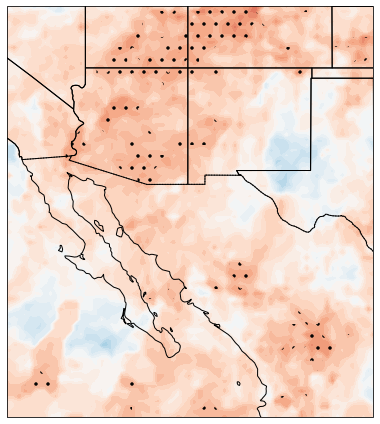

In [66]:
var1='sd'
var1_level=700
var1_month_list=[3, 4, 5]
var1_region='cp'
var2='onset'
var2_level=700
var2_month_list=[6, 7, 8]
var2_region='dsw'
ds = plot_correlation(var1=var1, var1_level=var1_level, var1_month_list=var1_month_list, var1_region=var1_region,
                     var2=var2, var2_level=var2_level, var2_month_list=var2_month_list, var2_region=var2_region)

In [ ]:
# calculate correlations for onset, length, and summer precipitation
var_list1 = sfc_accumu_list + sfc_instan_list + pl_var_list
var_list2 = NAM_var_list + ['tp']
region_list = ['dsw', 'cp']
for var1 in var_list1:
    for var2 in var_list2:
        for region in region_list:
            # with open(f'{der_script_path}corr.txt', 'a') as file:
            #     file.write(f'{var1} : {var2} : {region}\n')
            print(f'{var1} : {var2} : {region}')
            plot_correlation(var1=var1, var1_level=700, var1_month_list=[3, 4, 5], var1_region=region,
                             var2=var2, var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw')

sd : onset : cp


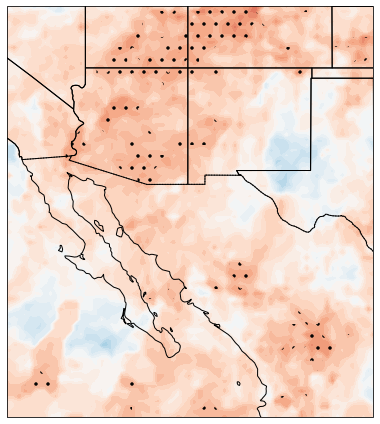

sd : retreat : cp


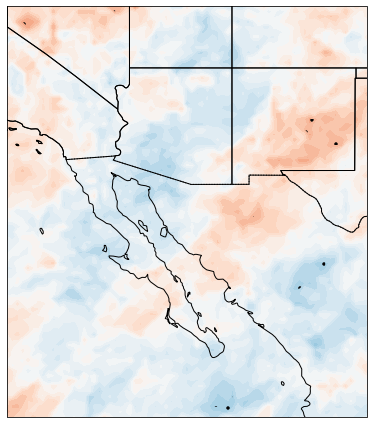

sd : length : cp


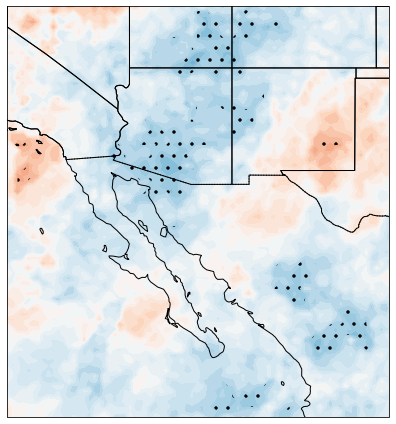

sd : tp : cp


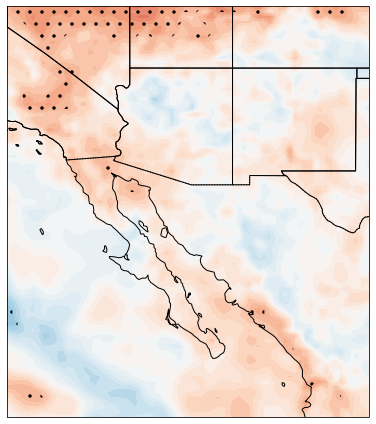

2t : onset : cp


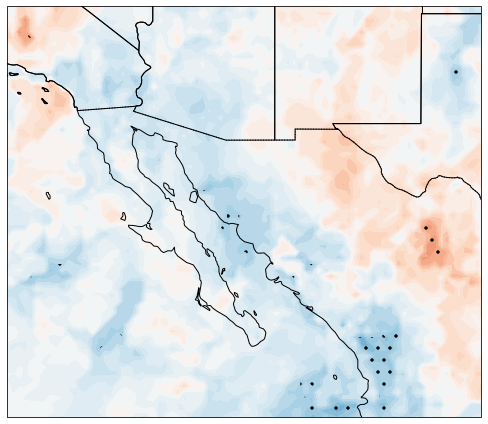

2t : retreat : cp


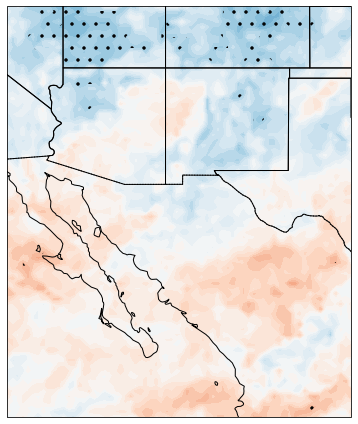

2t : length : cp


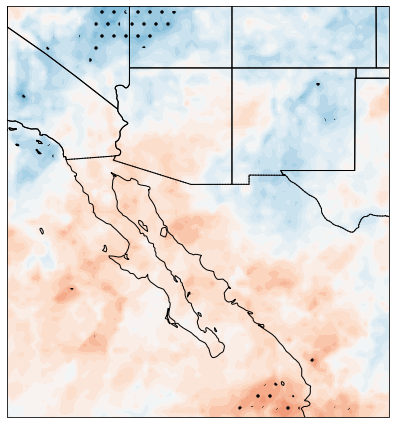

2t : tp : cp


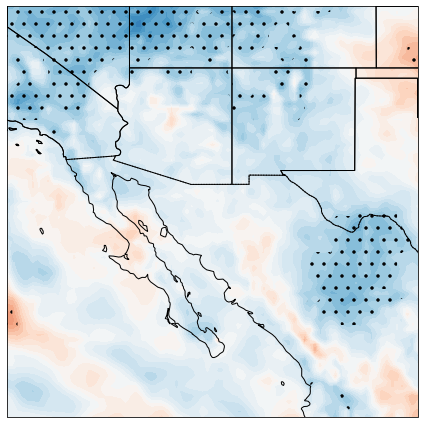

ie : onset : cp


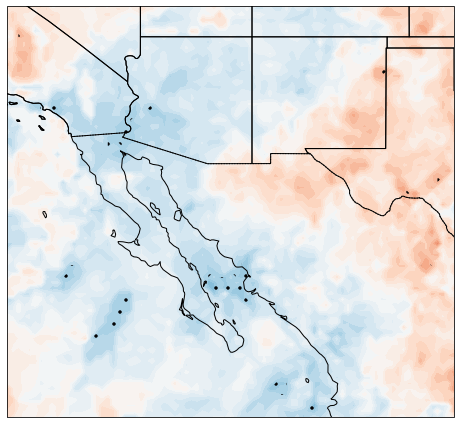

ie : retreat : cp


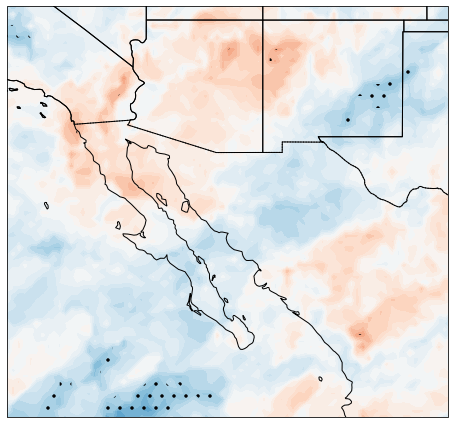

ie : length : cp


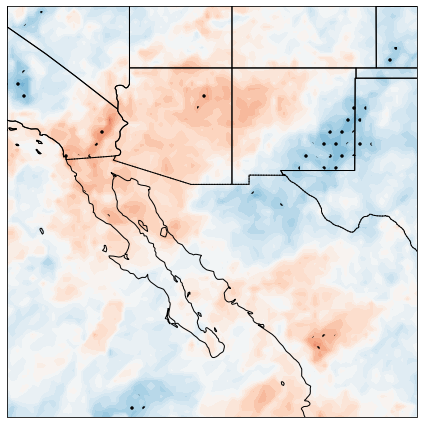

ie : tp : cp


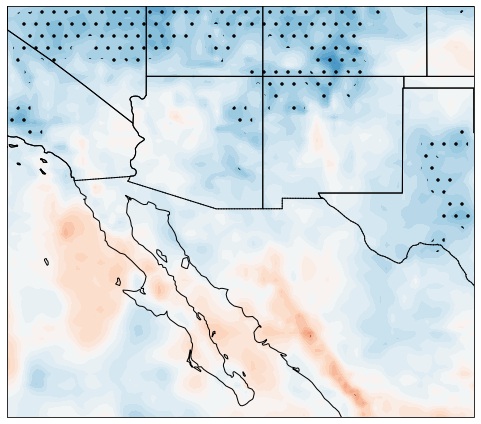

ishf : onset : cp


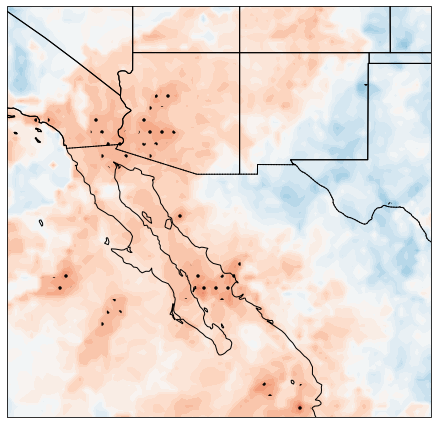

ishf : retreat : cp


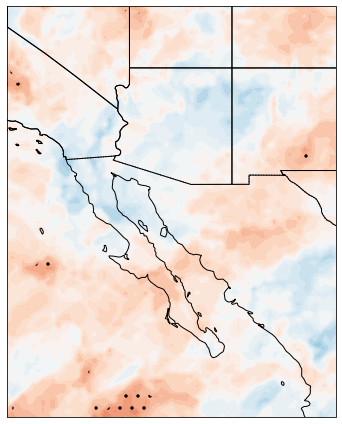

ishf : length : cp


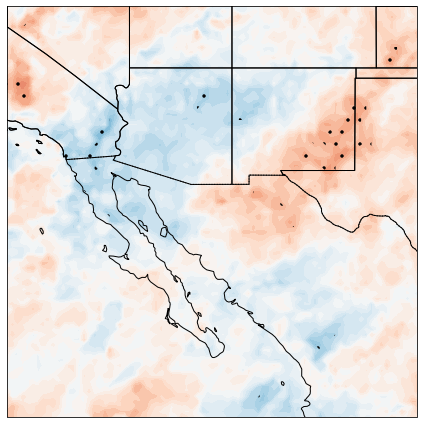

ishf : tp : cp


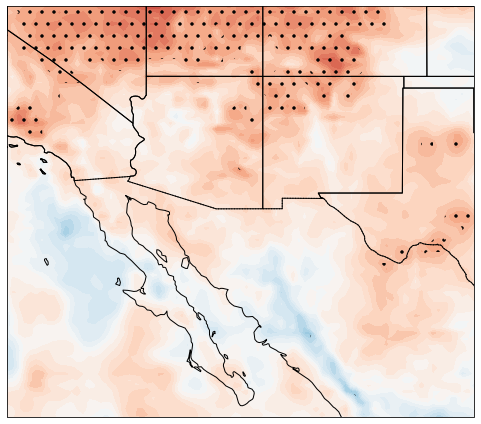

slhf : onset : cp


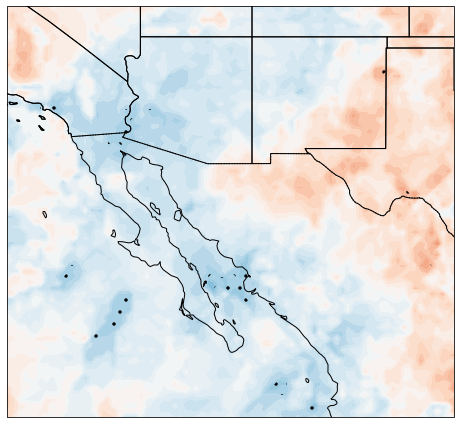

slhf : retreat : cp


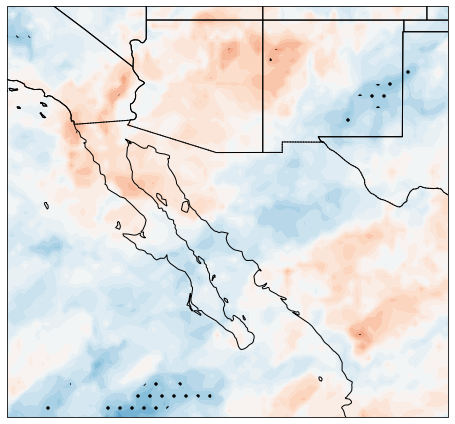

slhf : length : cp


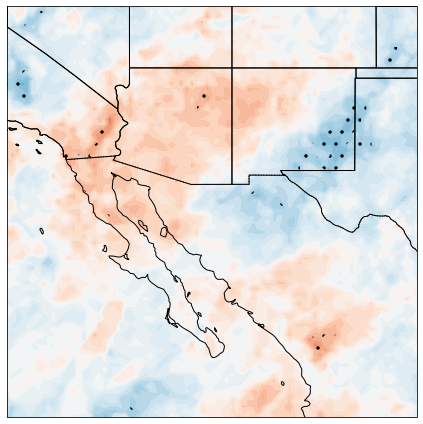

slhf : tp : cp


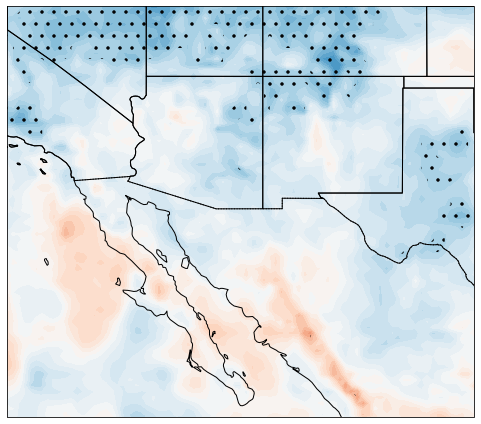

ssr : onset : cp


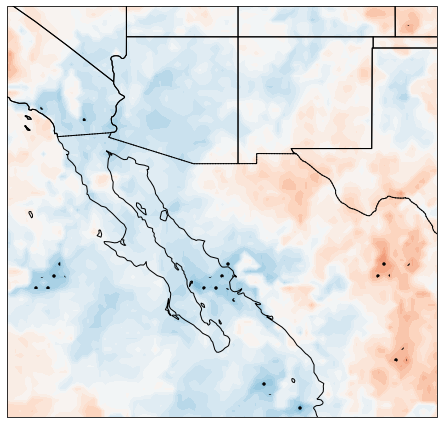

ssr : retreat : cp


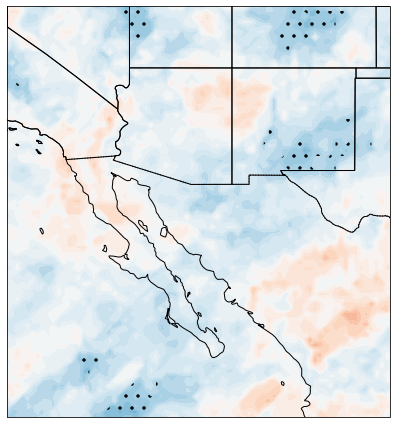

ssr : length : cp


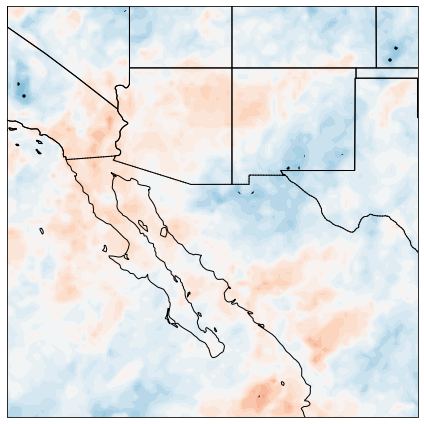

ssr : tp : cp


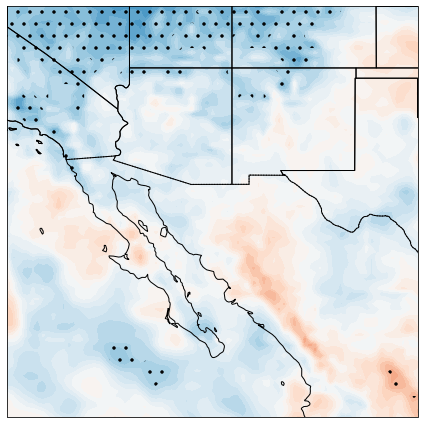

ssrd : onset : cp


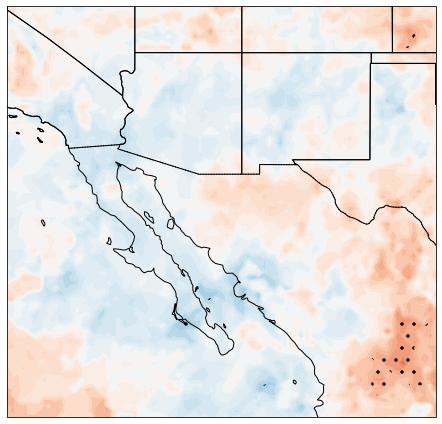

ssrd : retreat : cp


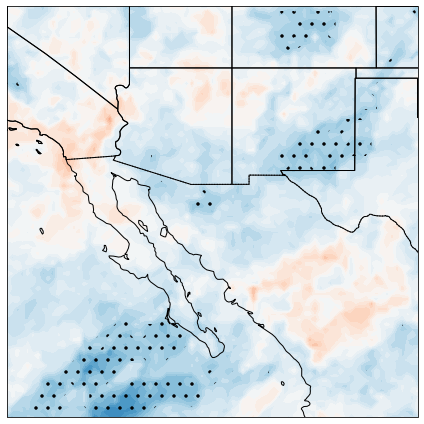

ssrd : length : cp


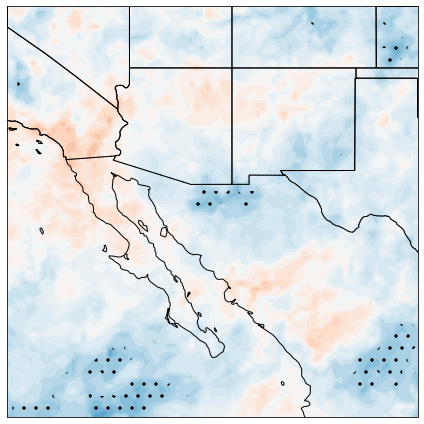

ssrd : tp : cp


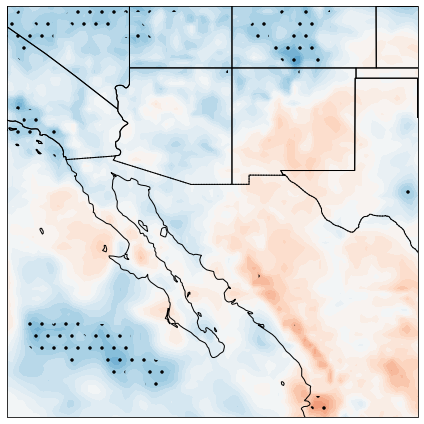

stl1 : onset : cp


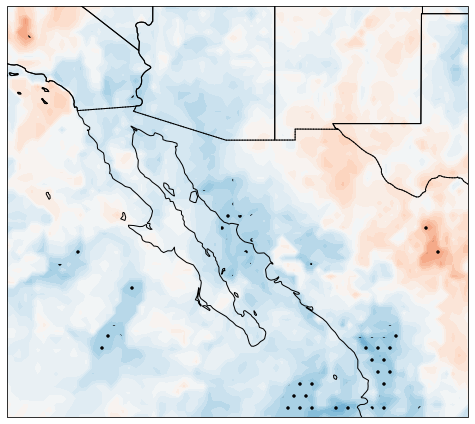

stl1 : retreat : cp


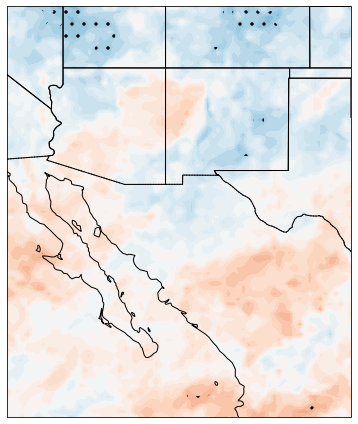

stl1 : length : cp


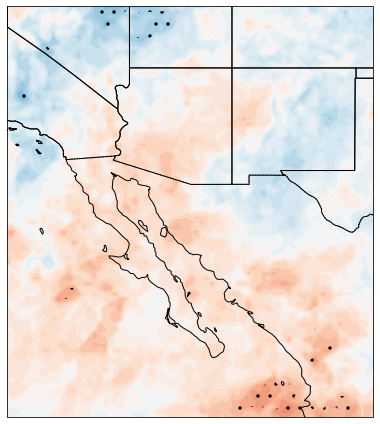

stl1 : tp : cp


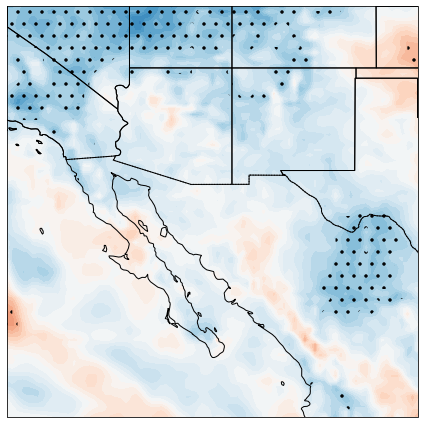

str : onset : cp


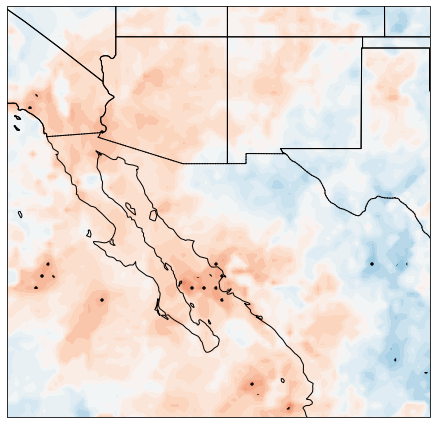

str : retreat : cp


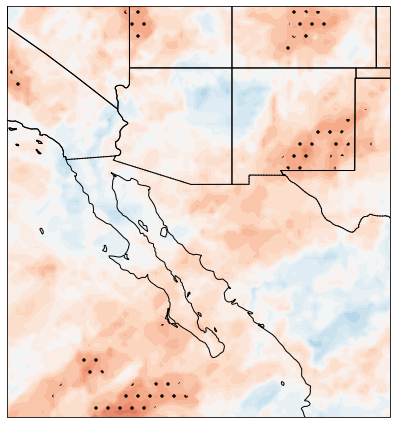

str : length : cp


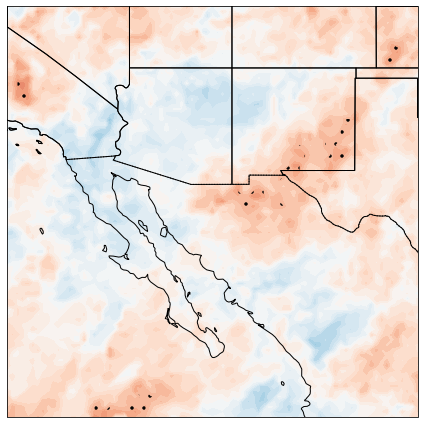

str : tp : cp


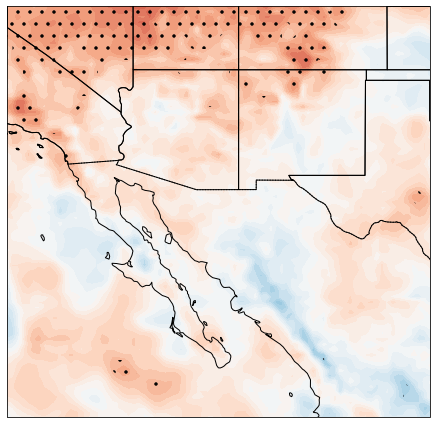

strd : onset : cp


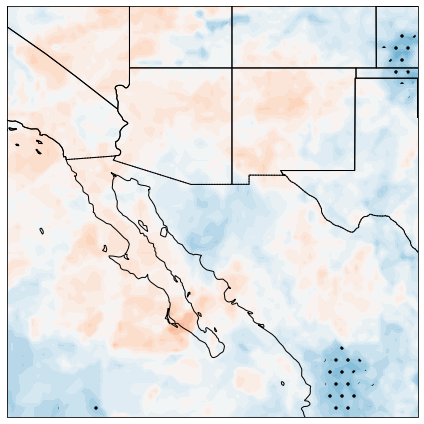

strd : retreat : cp


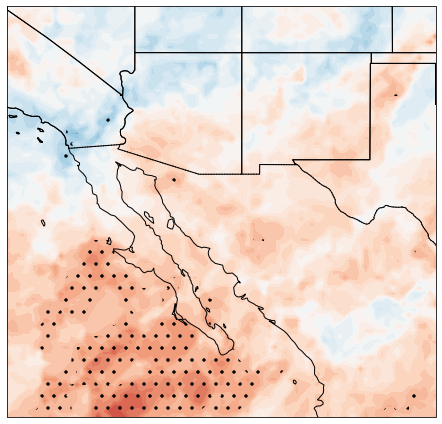

strd : length : cp


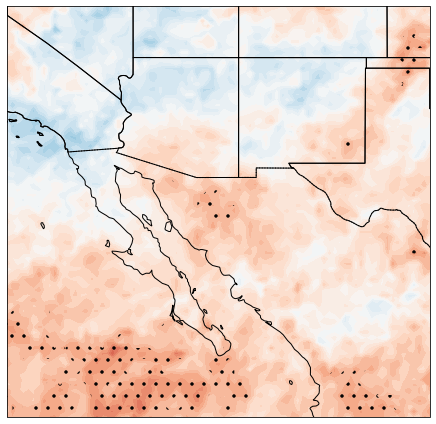

strd : tp : cp


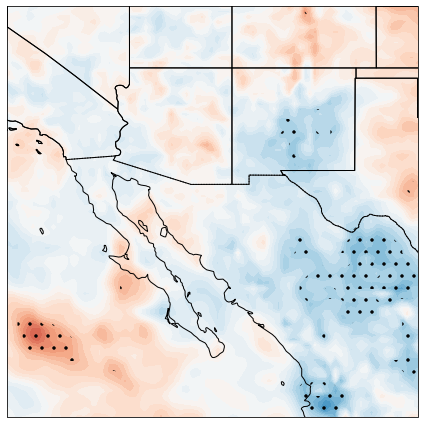

swvl1 : onset : cp


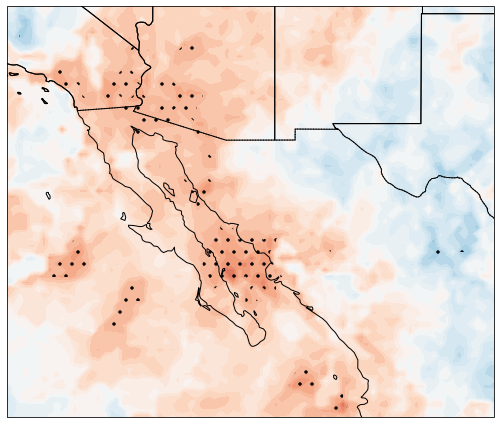

swvl1 : retreat : cp


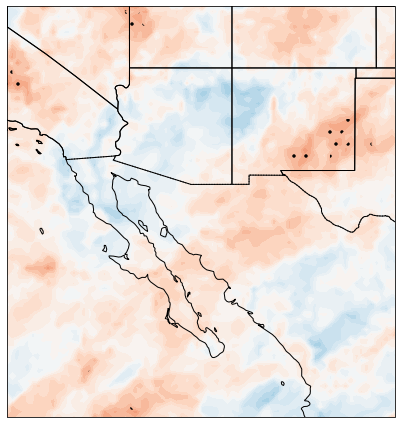

swvl1 : length : cp


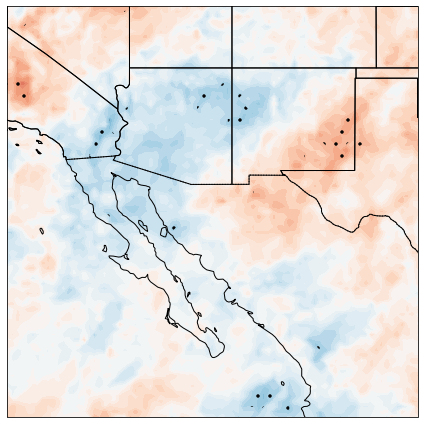

swvl1 : tp : cp


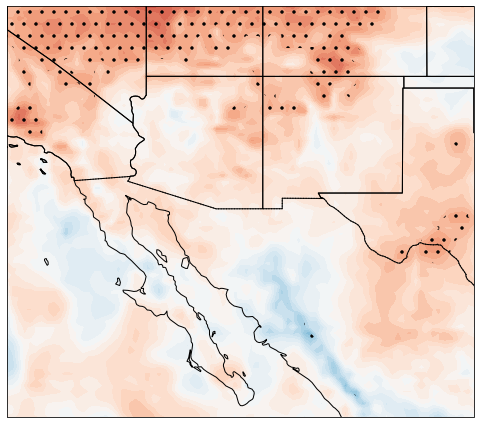

swvl2 : onset : cp


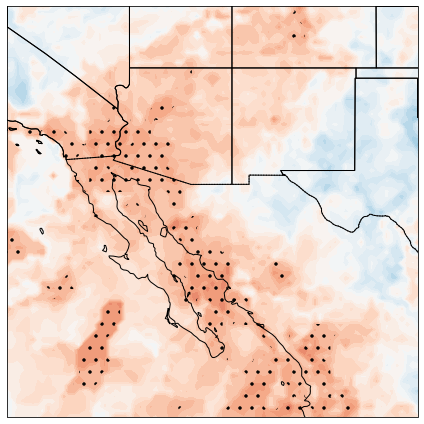

swvl2 : retreat : cp


/glade/u/home/zcleveland/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/glade/u/home/zcleveland/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/glade/u/home/zcleveland/.conda/envs/mland_xr/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


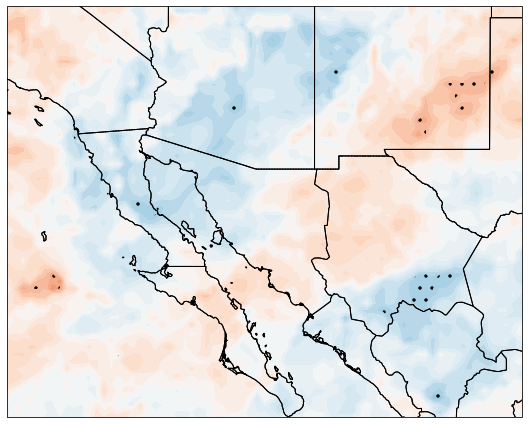

swvl2 : length : cp


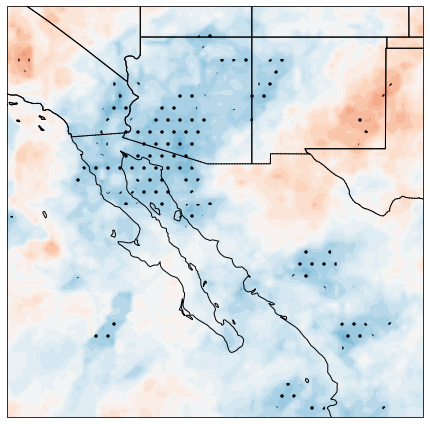

swvl2 : tp : cp


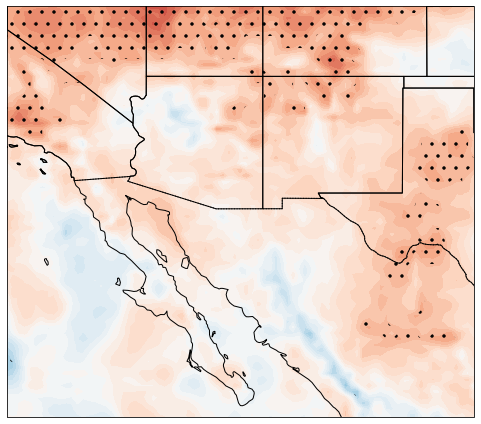

tcc : onset : cp


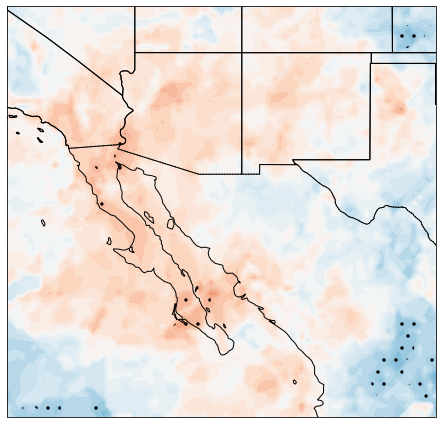

tcc : retreat : cp


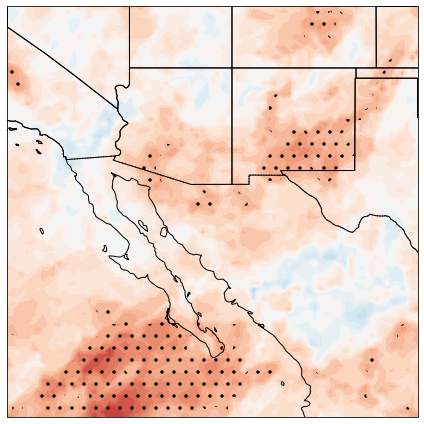

tcc : length : cp


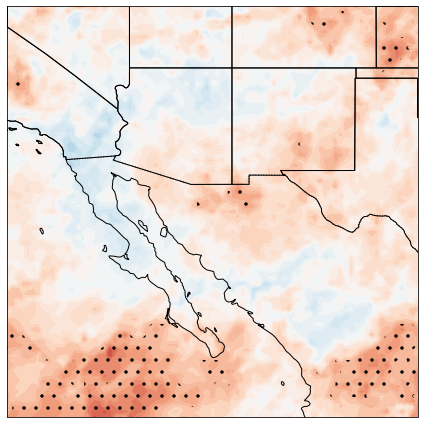

tcc : tp : cp


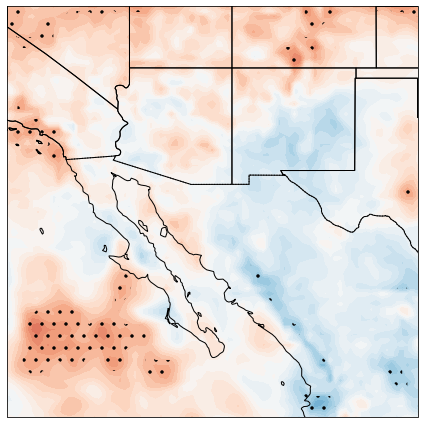

tp : onset : cp


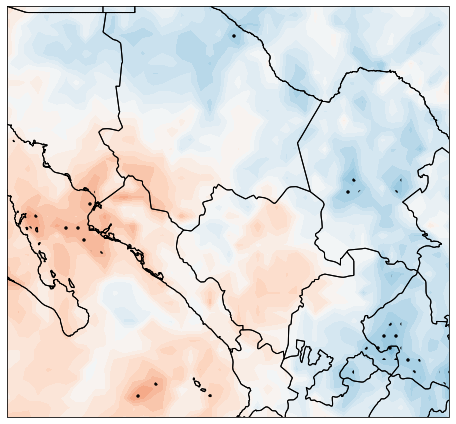

tp : retreat : cp


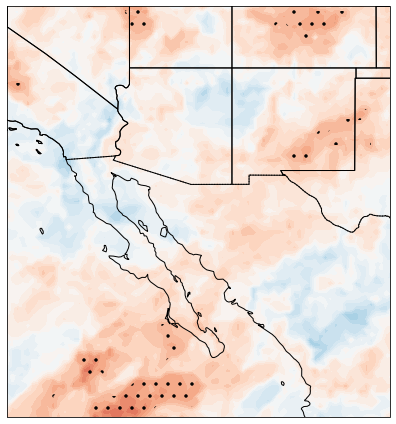

tp : length : cp


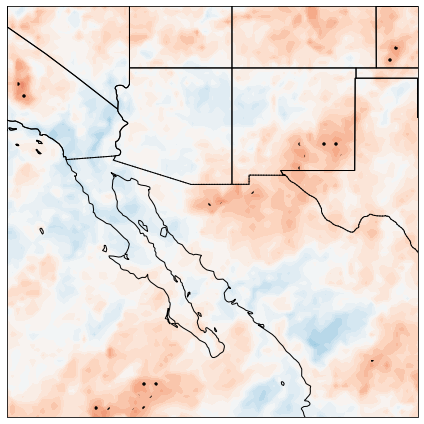

tp : tp : cp


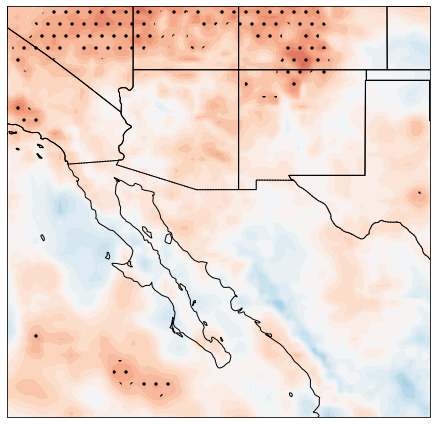

u : onset : cp


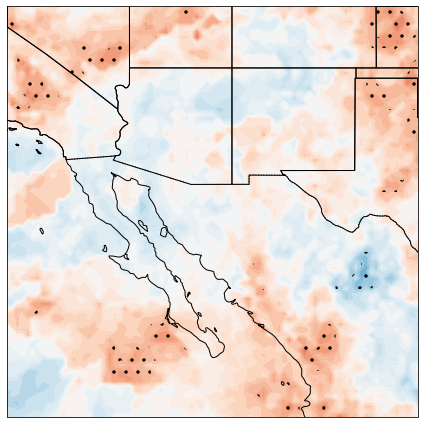

u : retreat : cp


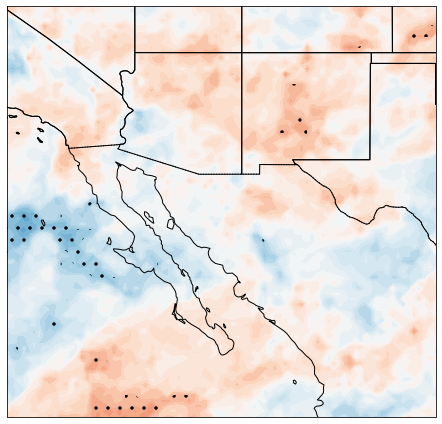

u : length : cp


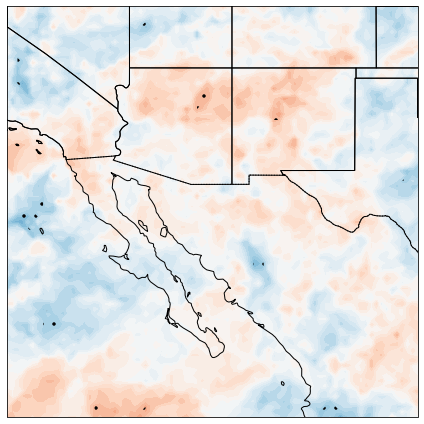

u : tp : cp


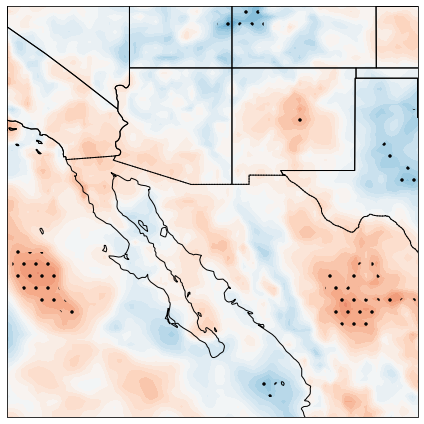

v : onset : cp


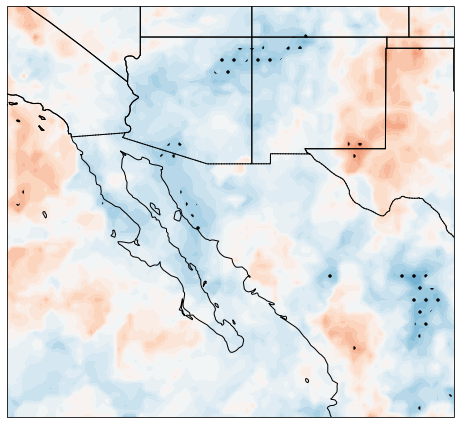

v : retreat : cp


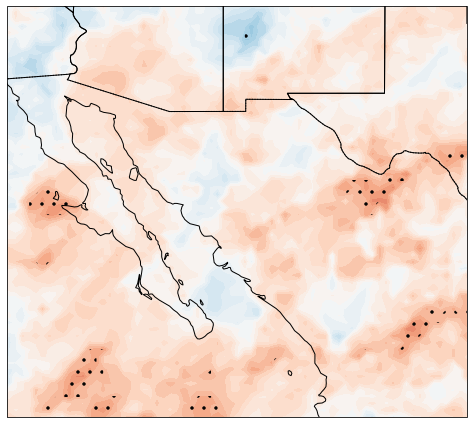

v : length : cp


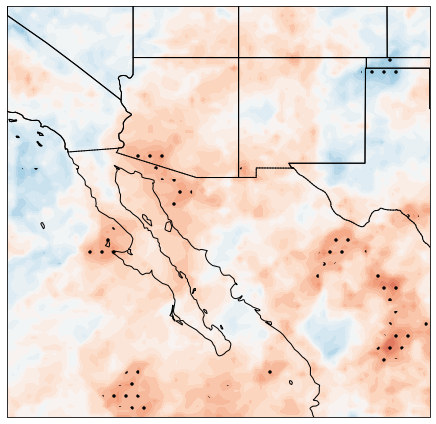

v : tp : cp


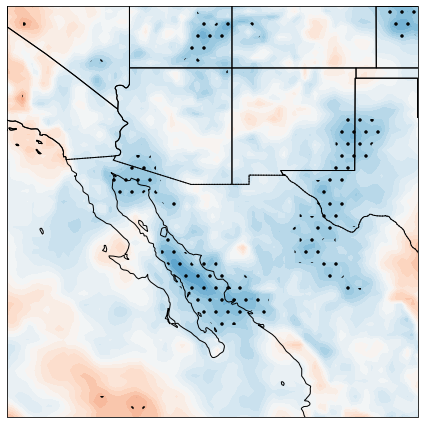

z : onset : cp


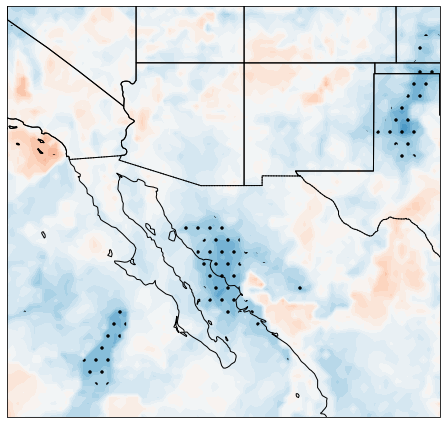

z : retreat : cp


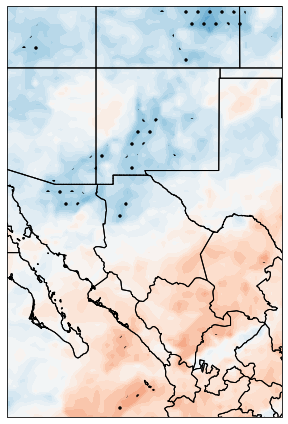

z : length : cp


KeyboardInterrupt: 

In [72]:
# calculate correlations for onset, retreat, length, and summer precipitation
# only certain variables
var_list1 = ['sd', '2t', 'ie', 'ishf', 'slhf', 'ssr', 'ssrd', 'stl1', 'str', 'strd', 'swvl1', 'swvl2', 'tcc', 'tp', 'u', 'v', 'z']
var_list2 = NAM_var_list + ['tp']
region_list = ['cp']
for var1 in var_list1:
    for var2 in var_list2:
        for region in region_list:
            # with open(f'{der_script_path}corr.txt', 'a') as file:
            #     file.write(f'{var1} : {var2} : {region}\n')
            print(f'{var1} : {var2} : {region}')
            plot_correlation(var1=var1, var1_level=700, var1_month_list=[3, 4, 5], var1_region=region,
                             var2=var2, var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw')

In [ ]:
# plot the global correlations
def plot_global_correlations(var1='ttr', var1_level=700, var1_month_list=[3, 4, 5], var1_region='global',
                             var2='tp', var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw'):

    # months list
    var1_months = month_num_to_name(var=var1, months=var1_month_list)
    var2_months = month_num_to_name(var=var2, months=var2_month_list)

    fn_list = [str(var1), str(var1_months), 'global', str(var2), str(var2_months), 'MeNmAz']
    fn_core = '_'.join([i for i in fn_list if i != ''])

    # filename and path
    in_fn = f'corr_{fn_core}.nc'
    in_fp = os.path.join(my_corr_path, 'global', in_fn)
    out_fn = f'corr_{fn_core}.png'
    out_fp = os.path.join(plot_out_path, 'global/temp', out_fn)

    # # check existence of file already
    # if os.path.exists(out_fp):
    #     print(f'File already exists for: {out_fn}')
    #     print('\nSkipping . . .')
    #     return

    # open dataset
    ds = xr.open_dataset(in_fp)
    da = ds['pearson_r']

    # create mask
    mask = np.abs(da) > .3
    da_masked = da.where(mask)

    # plot the results
    projection = ccrs.PlateCarree(central_longitude=180)
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=projection))

    levels = np.arange(-1, 1.05, 0.05)
    masked_levels = [-1, -0.3, 0.3, 1]
    # plot the data using contourf
    cf = plt.contourf(da.longitude, da.latitude,
                      da, levels=levels,
                      cmap='RdBu_r', vmin=-1, vmax=1, extend='both', transform=ccrs.PlateCarree())

    # overlay dots where absolute value of correlation is > .3
    cf_masked = plt.contourf(da_masked.longitude, da_masked.latitude,
                      da_masked, levels=masked_levels,
                      colors='none', vmin=-1, vmax=1, hatches='.', transform=ccrs.PlateCarree())

    # add coastlines, state borders, and other features
    ax.coastlines()
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    # ax.add_feature(cfeature.STATES)

    # plot features
    # plt.title(f'Correlation Between \n{var_dict[var1]} ({var1_region}, {var1_months}) \n& {var_dict[var2]} (MeNmAz)')
    # plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient', pad=0.02)
    plt.tight_layout()
    # plt.savefig(out_fp, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # return ds

File already exists for: corr_sstk_MAM_global_tp_JJA_MeNmAz.png

Skipping . . .


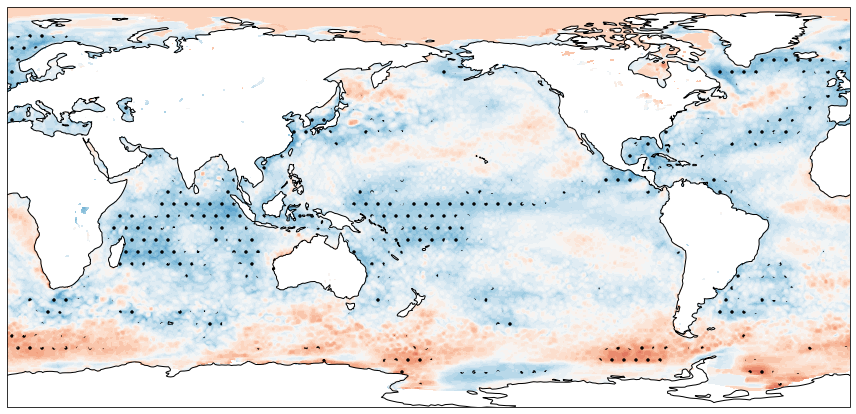

In [70]:
plot_global_correlations(var1='sstk', var1_level=700, var1_month_list=[3, 4, 5], var1_region='global',
                         var2='tp', var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw')

In [ ]:
var_list1 = ['sstk', 'ttr']
var_list2 = ['onset', 'retreat', 'length', 'tp']
var1_months_list = [
    [3, 4, 5],
    [6, 7, 8],
    [4],
    [5],
    [6]
]
for var1 in var_list1:
    for var2 in var_list2:
        for var1_month in var1_months_list:
            plot_global_correlations(var1=var1, var1_level=700, var1_month_list=var1_month, var1_region='global',
                                     var2=var2, var2_level=700, var2_month_list=[6, 7, 8], var2_region='dsw')